In [1]:
# install required system dependencies
!apt-get install -y xvfb x11-utils  
!apt-get install x11-utils > /dev/null 2>&1
!pip install PyOpenGL==3.1.* \
            PyOpenGL-accelerate==3.1.* \
            gym[box2d]==0.17.* 
!pip install pyglet
!pip install ffmpeg
! pip install pyvirtualdisplay
!pip install Image
!pip install gym-maze-trustycoder83

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [2]:
!mkdir ./vid
!rm ./vid/*.*

mkdir: cannot create directory ‘./vid’: File exists
rm: cannot remove './vid/*.*': No such file or directory


In [3]:
import sys
import numpy as np
import gym  
import gym_maze
from pyvirtualdisplay import Display
from gym.wrappers.monitoring import video_recorder
from matplotlib import pyplot as plt

d = Display()
d.start()

# Setup the environment for the maze
env = gym.make("maze-sample-10x10-v0")

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
#states_dic[0,3]

In [5]:
# defining number of episodes and maximum iterations
N_EPISODES = 20
MAX_ITER_EPISODE = 500

In [17]:
def perform_epsilon_greedy(ep, df, init=1):
  """
    Using ε-greedy algorithm.
    Params:
      ep: The exploration rate.
      df: discount factor.
      init: Initialization label. 1 for realistic and 2 for optimistic
  """
  if init not in [1,2]:
    return 'Error Initialization'
  global env
  current_state = env.reset()

  # initialization
  # Setting the random seed for reproducibility
  np.random.seed(7)

  # exploration probability which is given
  exploration_proba = ep

  states_dic = {} #dictionary to keep the states/coordinates of the Q table
  count = 0
  for i in range(10):
      for j in range(10):
          states_dic[i, j] = count
          count+=1
          
  n_actions = env.action_space.n

  if init == 1:
    # Initialize the Q-table to 0
    Q_table = np.zeros((len(states_dic),n_actions))
  else:
    # optimistic intialization
    Q_table = np.full((len(states_dic),n_actions), 0.5)

  # Step counter
  num_actions = 0

  rewards_per_episode = list()
  print('------------------------------------------------------')
  print('For ε: {} and 	γ: {}'.format(ep, df))
  print('------------------------')

  # Iterate over episodes
  for e in range(N_EPISODES):
      # We are not done yet
      done = False
      # Sum the rewards that the agent gets from the environment
      total_episode_reward = 0
      for i in range(MAX_ITER_EPISODE):
          # For each time step in each episode
          # env.unwrapped.render()
          # vid.capture_frame()
          current_coordinate_x = int(current_state[0])
          current_coordinate_y = int(current_state[1])
          current_Q_table_coordinates = states_dic[current_coordinate_x, current_coordinate_y]

          # Using ε-greedy algorithm
          if np.random.uniform(0,1) < exploration_proba:
            # exploration
            action = env.action_space.sample()
          else:
            # exploitation
            action = int(np.argmax(Q_table[current_Q_table_coordinates]))

          next_state, reward, done, _ = env.step(action)

          next_coordinate_x = int(next_state[0]) #get coordinates to be used in dictionary
          next_coordinate_y = int(next_state[1]) #get coordinates to be used in dictionary
          next_Q_table_coordinates = states_dic[next_coordinate_x, next_coordinate_y]

          # updating step counter
          num_actions += 1

          # Calculate learning rate
          lr = 1/num_actions

          # Update our Q-table using the Q-learning iteration
          Q_table[current_Q_table_coordinates, action] = Q_table[current_Q_table_coordinates, action] + lr*(reward - (df*max(Q_table[next_Q_table_coordinates,:])))
      
          total_episode_reward = total_episode_reward + reward
          # If the episode is finished, we leave the for loop
          if done:
              break
          current_state = next_state

      #Show the total episode reward        
      #Reset enviroment for next episode
      current_state = env.reset()
      rewards_per_episode.append(total_episode_reward)
  print("Total reward across all episodes:", sum(rewards_per_episode))
  return rewards_per_episode

In [18]:
# For realistic initialization where Q-value is set to 0 at start
dr_range = [0, .5, 1]
# ep_range = np.linspace(0,1,5)
ep_range = [0,0.01,0.1]
ep_dr_reward = []
for ep in ep_range:
  for dr in dr_range:
    ep_dr_reward.append(perform_epsilon_greedy(ep, dr))

------------------------------------------------------
For ε: 0 and 	γ: 0
------------------------
Total reward across all episodes: -8.878000000000004
------------------------------------------------------
For ε: 0 and 	γ: 0.5
------------------------
Total reward across all episodes: -8.930000000000005
------------------------------------------------------
For ε: 0 and 	γ: 1
------------------------
Total reward across all episodes: -8.933000000000005
------------------------------------------------------
For ε: 0.01 and 	γ: 0
------------------------
Total reward across all episodes: -8.658000000000005
------------------------------------------------------
For ε: 0.01 and 	γ: 0.5
------------------------
Total reward across all episodes: -8.930000000000005
------------------------------------------------------
For ε: 0.01 and 	γ: 1
------------------------
Total reward across all episodes: -8.662000000000004
------------------------------------------------------
For ε: 0.1 and 	γ: 0

For ε: 0


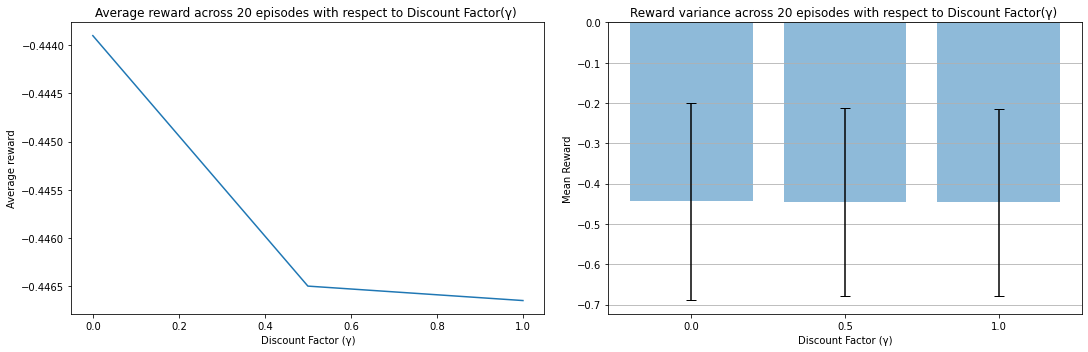

------------------------------------------------------------------------------------------------------------------------------------------------------------
For ε: 0.01


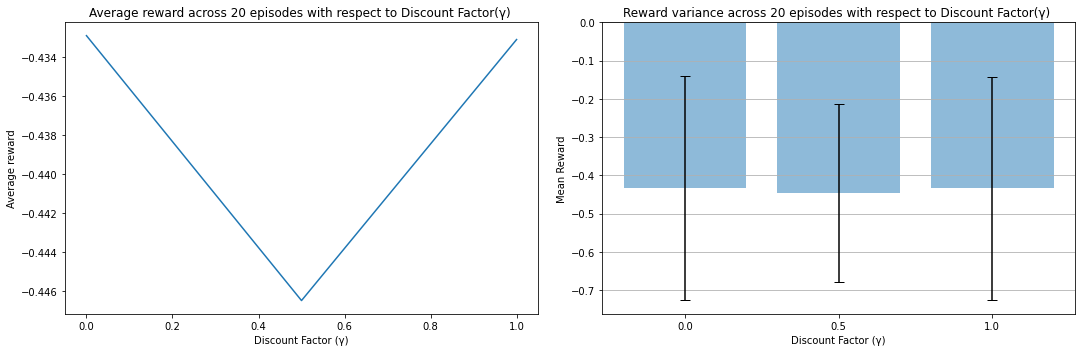

------------------------------------------------------------------------------------------------------------------------------------------------------------
For ε: 0.1


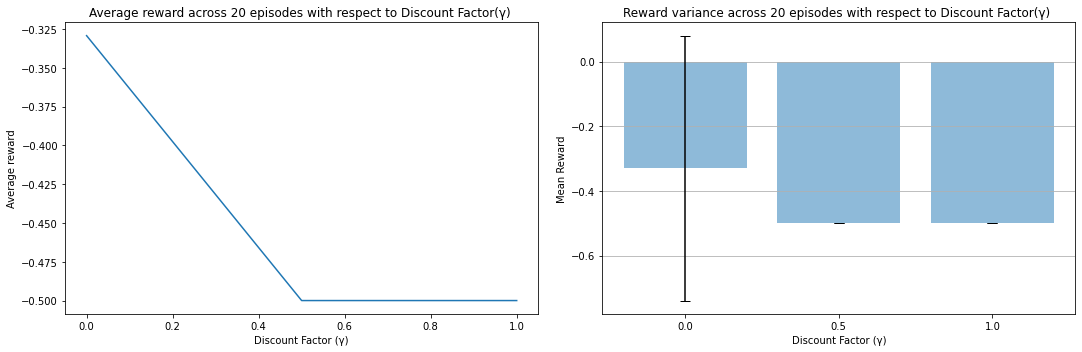

------------------------------------------------------------------------------------------------------------------------------------------------------------
Figs 1: Realistic Initialization


In [19]:
# average reward across N_EPISODES γ value for each ε value
ep_average_reward_list = []
for cnt, ep in enumerate(ep_range):
    # for each Exploration rate
    start_idx = cnt*3
    end_idx = (cnt+1)*3
    ep_reward_subset = ep_dr_reward[start_idx:end_idx]
    print('For ε: {}'.format(ep))
    # average reward across discount factor for each ε value
    ep_dr_reward_avg_list = []
    ep_dr_reward_std_list = []
    for dr_cnt, df_ep_reward_subset in enumerate(ep_reward_subset):
      # for each discount factor for the given outer loop exploration rate
      reward_avg = np.mean(df_ep_reward_subset)
      ep_dr_reward_avg_list.append(reward_avg)
      ep_dr_reward_std_list.append(np.std(df_ep_reward_subset))     # for the error plot

    # Plotting the  subplots
    # Error plot
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15,5))
    ax[1].bar(dr_range, ep_dr_reward_avg_list, yerr=ep_dr_reward_std_list, align='center', alpha=0.5, ecolor='black', capsize=5, width=[.4]*3)
    ax[1].set_title('Reward variance across {} episodes with respect to Discount Factor(γ) '.format(N_EPISODES))
    ax[1].set_ylabel('Mean Reward')
    ax[1].set_xlabel('Discount Factor (γ)')
    ax[1].yaxis.grid(True)
    ax[1].set_xticks(dr_range)
    plt.tight_layout()

    # Plotting in first line subplot  
    ax[0].plot(dr_range, ep_dr_reward_avg_list)
    ax[0].set_xlabel('Discount Factor (γ)')
    ax[0].set_ylabel('Average reward')
    ax[0].set_title('Average reward across {} episodes with respect to Discount Factor(γ) '.format(N_EPISODES))
    plt.show()
    # # getting average for entire epsilon value
    ep_average_reward_list.append(sum(ep_dr_reward_avg_list)/len(ep_dr_reward_avg_list))
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------')

print('Figs 1: Realistic Initialization')

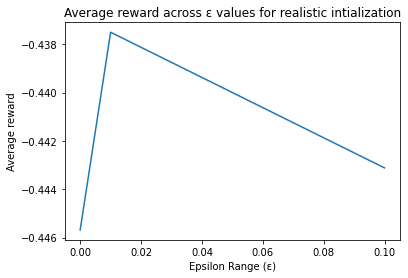

Fig 2: Realisitc Initialization


In [20]:
# For average reward across ε values
plt.title('Average reward across ε values for realistic intialization')
plt.plot(ep_range, ep_average_reward_list)
plt.xlabel('Epsilon Range (ε)')
plt.ylabel('Average reward')
plt.show()
print('Fig 2: Realisitc Initialization')

In [21]:
# For optimistic initialization
opt_ep_dr_reward = []
for ep in ep_range:
  for dr in dr_range:
    opt_ep_dr_reward.append(perform_epsilon_greedy(ep, dr, 2))

------------------------------------------------------
For ε: 0 and 	γ: 0
------------------------
Total reward across all episodes: -8.878000000000004
------------------------------------------------------
For ε: 0 and 	γ: 0.5
------------------------
Total reward across all episodes: -8.930000000000005
------------------------------------------------------
For ε: 0 and 	γ: 1
------------------------
Total reward across all episodes: -8.933000000000005
------------------------------------------------------
For ε: 0.01 and 	γ: 0
------------------------
Total reward across all episodes: -8.709000000000005
------------------------------------------------------
For ε: 0.01 and 	γ: 0.5
------------------------
Total reward across all episodes: -8.914000000000005
------------------------------------------------------
For ε: 0.01 and 	γ: 1
------------------------
Total reward across all episodes: -8.671000000000005
------------------------------------------------------
For ε: 0.1 and 	γ: 0

For ε: 0


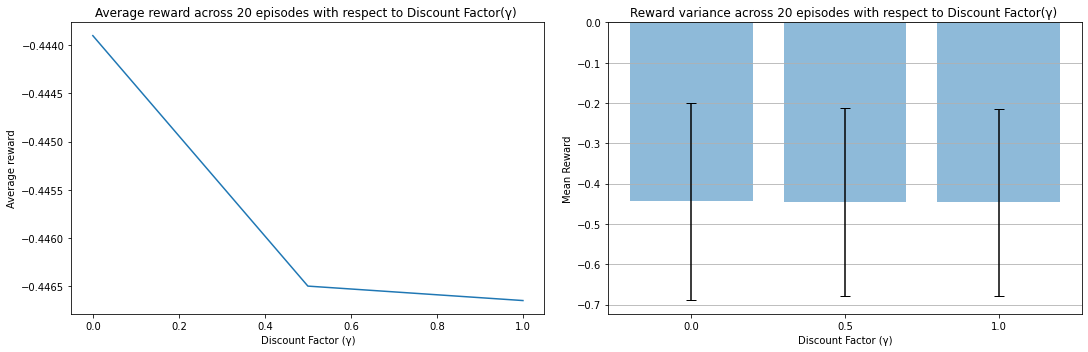

------------------------------------------------------------------------------------------------------------------------------------------------------------
For ε: 0.01


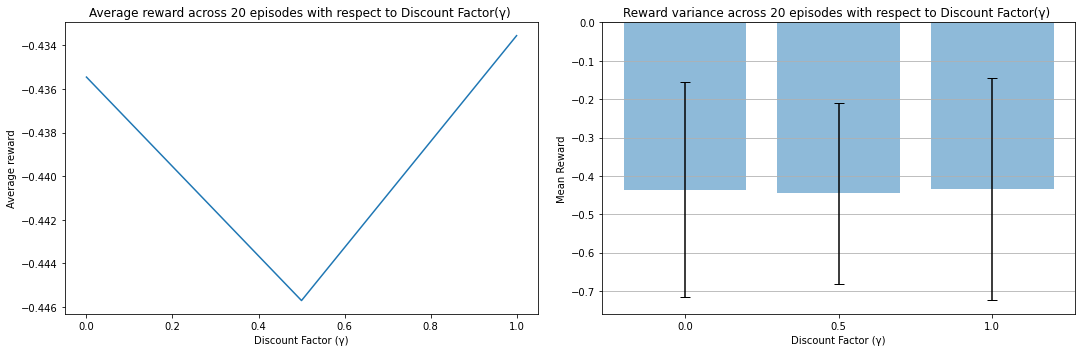

------------------------------------------------------------------------------------------------------------------------------------------------------------
For ε: 0.1


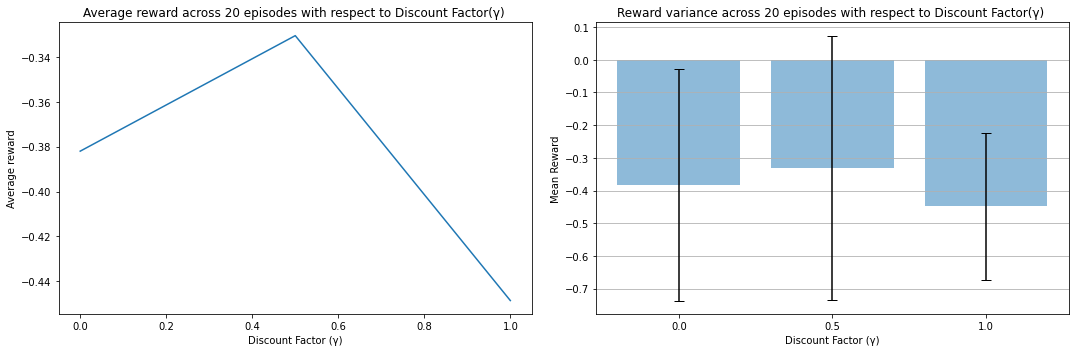

------------------------------------------------------------------------------------------------------------------------------------------------------------
Figs 3: Optimistic Initialization


In [22]:
# average reward across N_EPISODES γ value for each ε value
opt_ep_average_reward_list = []
for cnt, ep in enumerate(ep_range):
    # for each Exploration rate
    start_idx = cnt*3
    end_idx = (cnt+1)*3
    ep_reward_subset = opt_ep_dr_reward[start_idx:end_idx]
    print('For ε: {}'.format(ep))
    # average reward across discount factor for each ε value
    ep_dr_reward_avg_list = []
    ep_dr_reward_std_list = []
    for dr_cnt, df_ep_reward_subset in enumerate(ep_reward_subset):
      # for each discount factor for the given outer loop exploration rate
      reward_avg = np.mean(df_ep_reward_subset)
      ep_dr_reward_avg_list.append(reward_avg)
      ep_dr_reward_std_list.append(np.std(df_ep_reward_subset))     # for the error plot

    # Plotting the  subplots
    # Error plot
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15,5))
    ax[1].bar(dr_range, ep_dr_reward_avg_list, yerr=ep_dr_reward_std_list, align='center', alpha=0.5, ecolor='black', capsize=5, width=[.4]*3)
    ax[1].set_title('Reward variance across {} episodes with respect to Discount Factor(γ) '.format(N_EPISODES))
    ax[1].set_ylabel('Mean Reward')
    ax[1].set_xlabel('Discount Factor (γ)')
    ax[1].yaxis.grid(True)
    ax[1].set_xticks(dr_range)
    plt.tight_layout()

    # Plotting in first line subplot  
    ax[0].plot(dr_range, ep_dr_reward_avg_list)
    ax[0].set_xlabel('Discount Factor (γ)')
    ax[0].set_ylabel('Average reward')
    ax[0].set_title('Average reward across {} episodes with respect to Discount Factor(γ) '.format(N_EPISODES))
    plt.show()
    # # getting average for entire epsilon value
    opt_ep_average_reward_list.append(sum(ep_dr_reward_avg_list)/len(ep_dr_reward_avg_list))
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------')

print('Figs 3: Optimistic Initialization')

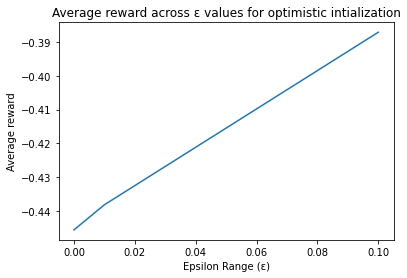

Fig 4: Optimisitc Initialization


In [23]:
plt.title('Average reward across ε values for optimistic intialization')
plt.plot(ep_range, opt_ep_average_reward_list)
plt.xlabel('Epsilon Range (ε)')
plt.ylabel('Average reward')
plt.show()
print('Fig 4: Optimisitc Initialization')

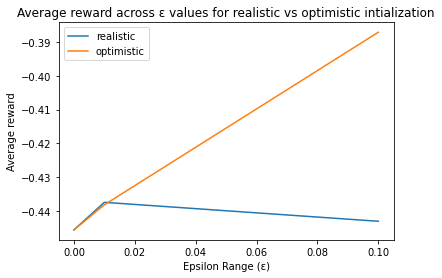

Fig 5: Realistic vs Optimistic Initialization


In [24]:
# For average reward across ε values
plt.title('Average reward across ε values for realistic vs optimistic intialization')
plt.plot(ep_range, ep_average_reward_list, label='realistic')
plt.plot(ep_range, opt_ep_average_reward_list, label='optimistic')
plt.xlabel('Epsilon Range (ε)')
plt.ylabel('Average reward')
plt.legend()
plt.show()
print('Fig 5: Realistic vs Optimistic Initialization')